<ipython-input-25-0c77120b0222>:60: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x[i] = np.datetime64(bucket['key_as_string'])


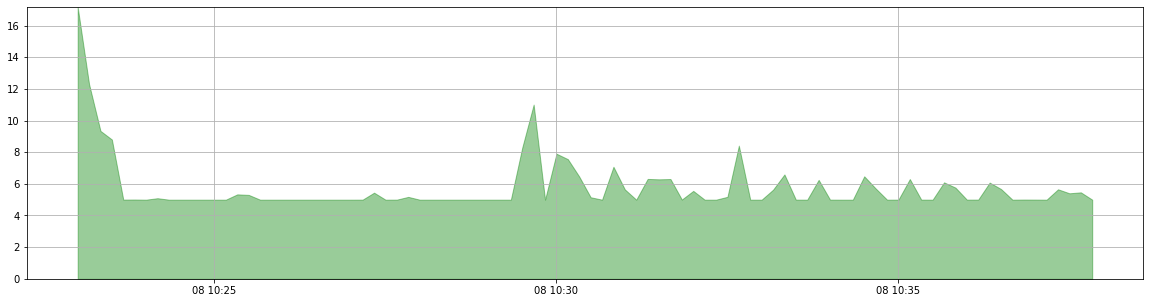

In [25]:
from datetime import datetime
from elasticsearch import Elasticsearch
import numpy as np
import matplotlib.pyplot as plt
import json

with open('credentials.json') as f:
    credentials = json.load(f)
    
es = Elasticsearch([f"http://{credentials['auth']}@{credentials['host']}"])

res = es.search(index="*_message", body={
  "aggs": {
    "eq_price": {
      "date_histogram": {
        "field": "sent_on",
        "fixed_interval": "10s"
      },
      "aggs": {
        "auctioneer": {
          "filter": {
            "term": {
              "channel": "trading-trials/auctioneer"
            }
          },
          "aggs": {
            "avg_price": {
              "avg": {
                "field": "metrics.price.dbl"
              }
            }
          }
        }
      }
    }
  },
  "size": 0,
  "query": {
    "bool": {
      "filter": [
        {
          "range": {
            "sent_on": {
                "gte" : "now-15m/m",
                "lt" :  "now/m"
            }
          }
        }
      ]
    }
  }
})

buckets = res['aggregations']['eq_price']['buckets']
x = np.zeros(len(buckets), dtype='datetime64[ms]')
y = np.zeros(len(buckets))
for i, bucket in enumerate(buckets):
    auctioneer = bucket['auctioneer']
    y[i] = auctioneer['avg_price']['value']
    x[i] = np.datetime64(bucket['key_as_string'])
    
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=np.max(y))
ax.fill_between(x,y,color='g',alpha=0.4)
ax.grid(True)
plt.show()